In [1]:
import pandas as pd
import numpy as np

def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())


df = normalize_feature(pd.read_csv('data1.csv',
                                   names=['square', 'bedrooms', 'price']))

ones = pd.DataFrame({'ones': np.ones(len(df))})# ones是n行1列的数据框，表示x0恒为1
df = pd.concat([ones, df], axis=1)  # 根据列合并数据

X_data = np.array(df[df.columns[0:3]])
y_data = np.array(df[df.columns[-1]]).reshape(len(df), 1)

print(X_data.shape, type(X_data))
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


## 创建线性回归模型（数据流图）

In [2]:
import tensorflow as tf

alpha = 0.01 # 学习率 alpha
epoch = 500 # 训练全量数据集的轮数

with tf.name_scope('input'):
    # 输入 X，形状[47, 3]
    X = tf.placeholder(tf.float32, X_data.shape, name='X')
    # 输出 y，形状[47, 1]
    y = tf.placeholder(tf.float32, y_data.shape, name='y')

with tf.name_scope('hypothesis'):
    # 权重变量 W，形状[3,1]
    W = tf.get_variable("weights",
                        (X_data.shape[1], 1),
                        initializer=tf.constant_initializer())
    # 假设函数 h(x) = w0*x0+w1*x1+w2*x2, 其中x0恒为1
    # 推理值 y_pred  形状[47,1]
    y_pred = tf.matmul(X, W, name='y_pred')

with tf.name_scope('loss'):
    # 损失函数采用最小二乘法，y_pred - y 是形如[47, 1]的向量。
    # tf.matmul(a,b,transpose_a=True) 表示：矩阵a的转置乘矩阵b，即 [1,47] X [47,1]
    # 损失函数操作 loss
    loss_op = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)
with tf.name_scope('train'):
    # 随机梯度下降优化器 opt
    train_op = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(loss_op)

## 创建会话（运行环境）

In [3]:
with tf.Session() as sess:
    # 初始化全局变量
    sess.run(tf.global_variables_initializer())
    # 创建FileWriter实例，并传入当前会话加载的数据流图
    writer = tf.summary.FileWriter('./summary/linear-regression-1', sess.graph)
    # 记录所有损失值
    loss_data = []
    # 开始训练模型
    # 因为训练集较小，所以采用批梯度下降优化算法，每次都使用全量数据训练
    for e in range(1, epoch + 1):
        _, loss, w = sess.run([train_op, loss_op, W], feed_dict={X: X_data, y: y_data})
        # 记录每一轮损失值变化情况
        loss_data.append(float(loss))
        if e % 100 == 0:
            log_str = "Epoch %d \t Loss=%.4g \t Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))

# 关闭FileWriter的输出流
writer.close()            

Epoch 100 	 Loss=0.1835 	 Model: y = 0.4909x1 + 0.1621x2 + -6.147e-10
Epoch 200 	 Loss=0.1483 	 Model: y = 0.6678x1 + 0.1255x2 + 2.119e-10
Epoch 300 	 Loss=0.1379 	 Model: y = 0.7522x1 + 0.07118x2 + 5.087e-10
Epoch 400 	 Loss=0.1337 	 Model: y = 0.8004x1 + 0.02938x2 + 1.694e-09
Epoch 500 	 Loss=0.132 	 Model: y = 0.8304x1 + 0.0008239x2 + 4.138e-09


## 可视化损失值

In [4]:
print(len(loss_data))

500


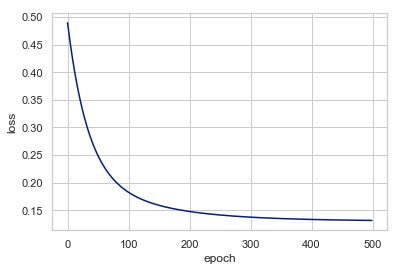

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")

ax = sns.lineplot(x='epoch', y='loss', data=pd.DataFrame({'loss': loss_data, 'epoch': np.arange(epoch)}))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()